![Open Screen](https://github.com/Slenderman00/open_screen/blob/master/media/banner.png?raw=true)

### Downloads the dataset

In [1]:
import os
import subprocess
from IPython.display import clear_output

cwd = os.getcwd()
if not os.path.exists(f'{cwd}/dataset'):
    process = subprocess.Popen('bash download_dataset.sh', shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
    for stdout_line in iter(process.stdout.readline, ""):
        clear_output(wait=True)
        print(stdout_line, end="")
    process.stdout.close()
    process.wait()
    assert process.returncode == 0
    print('Finished downloading and extracting')


### Calculate mean and std

In [2]:
import os
from PIL import Image
import torch
from torchvision import transforms

cwd = os.getcwd()

sums = torch.zeros(3)
squared_sums = torch.zeros(3)
count = 0

for image in os.listdir(f'{cwd}/dataset/image'):
    image = f'{cwd}/dataset/image/{image}'
    image = Image.open(image).convert('RGB')

    image_tensor = transforms.ToTensor()(image)

    sums += image_tensor.sum(dim=[1, 2])
    squared_sums += (image_tensor ** 2).sum(dim=[1, 2])
    count += image_tensor.size(1) * image_tensor.size(2)

mean = sums / count
std = (squared_sums / count - mean ** 2) ** 0.5

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.3375, 0.6341, 0.3071])
Std: tensor([0.3380, 0.3459, 0.3206])


### Create a custom dataset loader for pytorch

In [3]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

image_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the images to a fixed size
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize(mean, std), # Normalise data
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),   # Resize the masks to a fixed size
    transforms.Grayscale(),          # Convert masks to grayscale if they are not already
    transforms.ToTensor(),        # Convert the masks to tensors
])

class CustomLoader(Dataset):
    def __init__(self, device='cpu'):
        self.device = device
        self.cwd = os.getcwd()
        self.len = len(os.listdir(f'{self.cwd}/dataset/image'))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image_path = f'{self.cwd}/dataset/image/{idx}.jpg'
        mask_path = f'{self.cwd}/dataset/mask/{idx}.png'

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

        # Apply the transformations
        image_tensor = image_transform(image).float()
        mask_tensor = mask_transform(mask).float()

        # If mask is not single-channel, take the first channel
        if mask_tensor.size(0) != 1:
            mask_tensor = mask_tensor[0].unsqueeze(0)

        # Move tensors to the specified device
        image_tensor = image_tensor.to(self.device)
        mask_tensor = mask_tensor.to(self.device)

        return {'images': image_tensor, 'masks': mask_tensor}

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleSegmentationModel(nn.Module):
    def __init__(self):
        super(SimpleSegmentationModel, self).__init__()
        # Encoder
        self.enc_conv1a = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)
        
        # Decoder
        self.dec_conv1a = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv1b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_conv2a = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        

    def forward(self, x):
        # Encoder
        x1 = F.relu(self.enc_bn1(self.enc_conv1a(x)))
        x1 = F.relu(self.enc_bn1(self.enc_conv1b(x1)))
        x1p = self.pool(x1)
        x2 = F.relu(self.enc_bn2(self.enc_conv2a(x1p)))
        x2 = F.relu(self.enc_bn2(self.enc_conv2b(x2)))
        x2p = self.pool(x2)
        x3 = F.relu(self.enc_bn3(self.enc_conv3a(x2p)))
        x3 = F.relu(self.enc_bn3(self.enc_conv3b(x3)))
        
        # Decoder
        x3u = self.upsample(x3)
        x2d = F.relu(self.dec_bn1(self.dec_conv1a(x3u)))
        x2d = F.relu(self.dec_bn1(self.dec_conv1b(x2d)))
        x1u = self.upsample(x2d)
        x1d = F.relu(self.dec_bn2(self.dec_conv2a(x1u)))
        x1d = F.relu(self.dec_bn2(self.dec_conv2b(x1d)))
        x_out = self.dec_conv3(x1d)

        x_out = torch.sigmoid(x_out)

        return x_out

    def forward_with_activations(self, x):
        activations = {}
        
        # Encoder
        x1 = F.relu(self.enc_bn1(self.enc_conv1a(x)))
        activations['enc_conv1a'] = x1
        x1 = F.relu(self.enc_bn1(self.enc_conv1b(x1)))
        activations['enc_conv1b'] = x1
        x1p = self.pool(x1)
        activations['pool1'] = x1p
        x2 = F.relu(self.enc_bn2(self.enc_conv2a(x1p)))
        activations['enc_conv2a'] = x2
        x2 = F.relu(self.enc_bn2(self.enc_conv2b(x2)))
        activations['enc_conv2b'] = x2
        x2p = self.pool(x2)
        activations['pool2'] = x2p
        x3 = F.relu(self.enc_bn3(self.enc_conv3a(x2p)))
        activations['enc_conv3a'] = x3
        x3 = F.relu(self.enc_bn3(self.enc_conv3b(x3)))
        activations['enc_conv3b'] = x3
        
        # Decoder
        x3u = self.upsample(x3)
        activations['upsample1'] = x3u
        x2d = F.relu(self.dec_bn1(self.dec_conv1a(x3u)))
        activations['dec_conv1a'] = x2d
        x2d = F.relu(self.dec_bn1(self.dec_conv1b(x2d)))
        activations['dec_conv1b'] = x2d
        x1u = self.upsample(x2d)
        activations['upsample2'] = x1u
        x1d = F.relu(self.dec_bn2(self.dec_conv2a(x1u)))
        activations['dec_conv2a'] = x1d
        x1d = F.relu(self.dec_bn2(self.dec_conv2b(x1d)))
        activations['dec_conv2b'] = x1d
        x_out = self.dec_conv3(x1d)
        activations['dec_conv3'] = x_out
        
        # Output
        x_out = torch.sigmoid(x_out)  # Sigmoid activation to output probabilities

        return activations, x_out

In [5]:
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleSegmentationModel().to(device)

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
batch_size = 1
debug = False

In [7]:
from torch.utils.data import DataLoader, random_split

train_dataset = CustomLoader(device=device)

validation_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - validation_size

train_subset, validation_subset = random_split(train_dataset, [train_size, validation_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In Validation


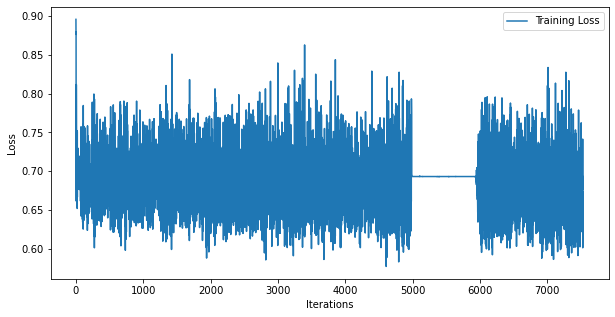

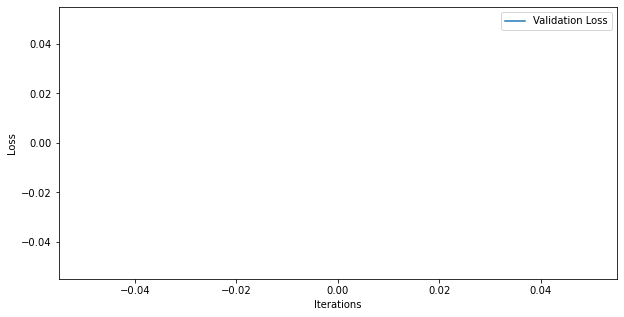

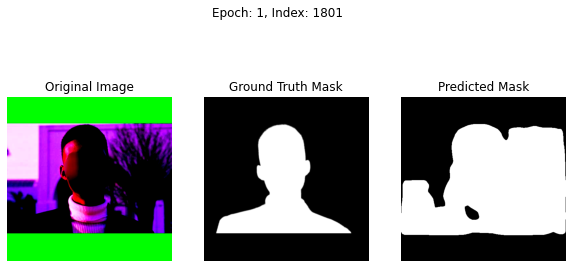

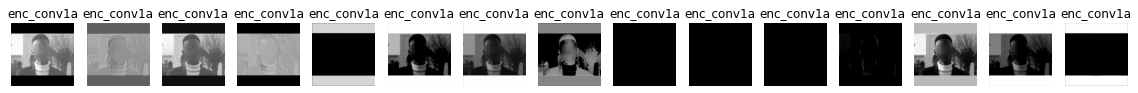

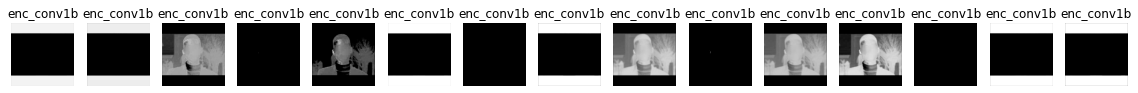

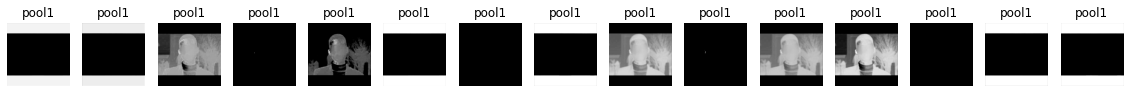

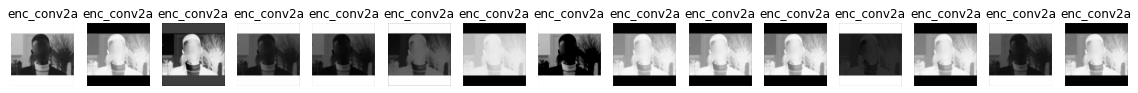

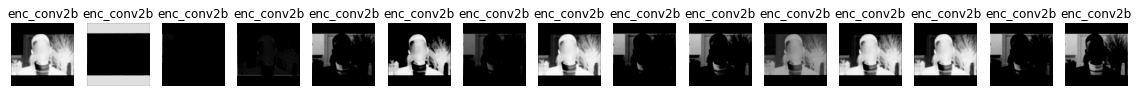

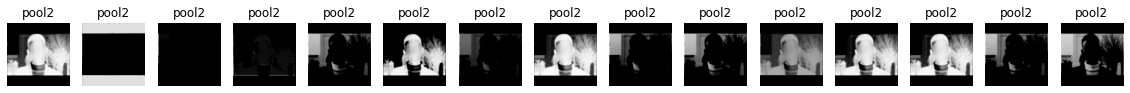

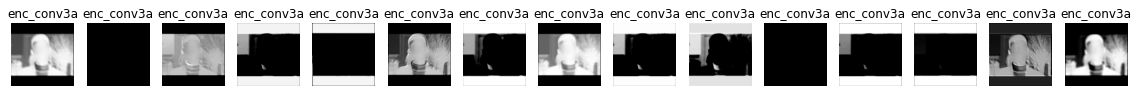

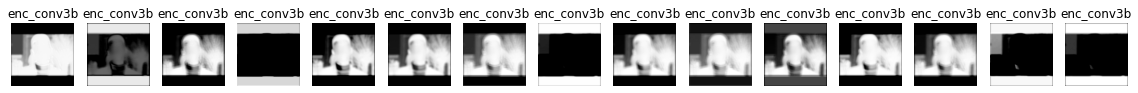

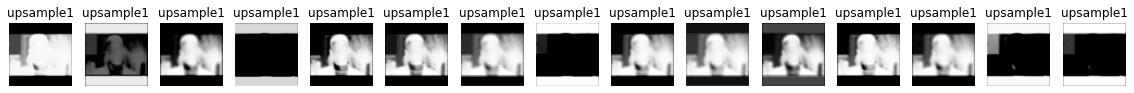

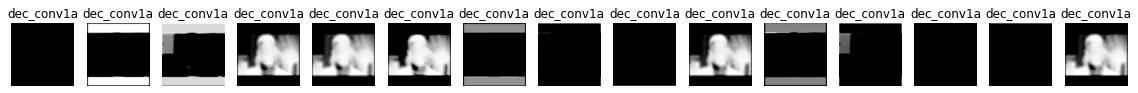

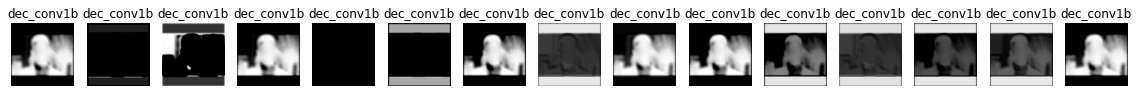

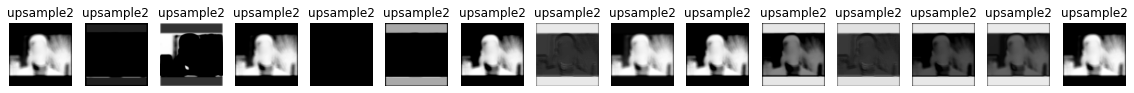

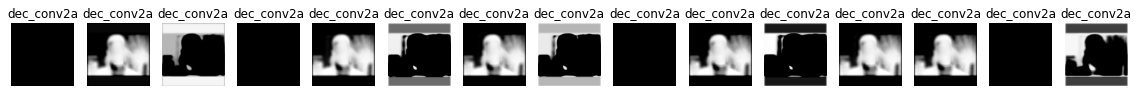

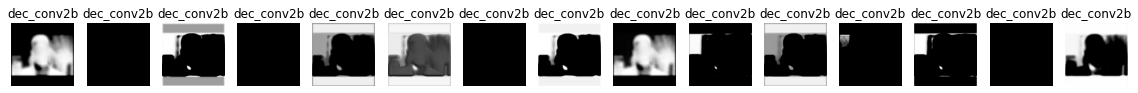

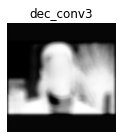

Epoch [1], Validation Loss: 0.7704105616216953


KeyboardInterrupt: 

In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt


def visualize_activations(activations):
    for name, activation in activations.items():
        num_feature_maps = activation.size(1)
        
        num_feature_maps_to_display = min(num_feature_maps, 15)
        
        fig, axes = plt.subplots(1, num_feature_maps_to_display, figsize=(20, 2))
        if num_feature_maps_to_display == 1:
            axes = [axes]
            
        for i in range(num_feature_maps_to_display):
            # We detach the tensor from the GPU and convert to numpy for visualization
            feature_map = activation[0, i].detach().cpu().numpy()
            axes[i].set_title(name)
            axes[i].imshow(feature_map, cmap='gray')
            axes[i].axis('off')

def plot_masks(image, true_mask, pred_mask, epoch, idx, loss_values, val_loss_values):
    clear_output(wait=True)

    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    pred_mask_np = pred_mask.squeeze().detach().cpu().numpy()

    if true_mask is not None:
        true_mask_np = true_mask.squeeze().cpu().numpy()

        axs[1].imshow(true_mask_np, cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
    
    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[0].axis('off') 
    
    axs[2].imshow(pred_mask_np, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    
    plt.suptitle(f'Epoch: {epoch}, Index: {idx}')

loss_values = []
val_loss_values = []

for epoch in range(100):
    model.train()
    for i, sample in enumerate(train_loader):
        images, masks = sample['images'], sample['masks']
        optimizer.zero_grad()
        if (i + epoch) % 500 == 0 and debug:
            activations, outputs = model.forward_with_activations(images)
        else:
            outputs = model(images)  

        loss = criterion(outputs, masks) 
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())
        if (i + epoch) % 500 == 0:

            pred_mask = outputs > 0.5  # Apply threshold to get binary mask
            plot_masks(images, masks, pred_mask, epoch+1, i+1, loss_values, val_loss_values)
            print(f'Epoch [{epoch+1}], Loss: {loss.item()}')
            if debug:
                visualize_activations(activations)
            plt.show()

 
    torch.save(model.state_dict(), f'backups/epoch{epoch}.pth')



    # Validation step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients for validation
        val_loss = 0
        for i, sample in enumerate(validation_loader):
            images, masks = sample['images'], sample['masks']
            activations, outputs = model.forward_with_activations(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            if (i + epoch) % 100 == 0 and debug:
                pred_mask = outputs > 0.5  # Apply threshold to get binary mask
                plot_masks(images, masks, pred_mask, epoch+1, i+1, loss_values, val_loss_values)
                print('In Validation')
                visualize_activations(activations)
                plt.show()


        val_loss /= len(validation_loader)
        val_loss_values.append(val_loss)
        print(f'Epoch [{epoch+1}], Validation Loss: {val_loss}')

In [ ]:
# save the model
torch.save(model.state_dict(), 'cnn.pth')
